<a href="https://colab.research.google.com/github/Stefi96/DetectingNFTs-Master/blob/main/Domains_NFT_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Lets import the libraries and code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import IsolationForest
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GRU, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

In [ ]:
# Load the  uploaded datasets
scam_data = pd.read_csv('/content/drive/MyDrive/Master/Project/Domains/final_blocklist_domains.csv')
legit_data = pd.read_csv('/content/drive/MyDrive/Master/Project/Domains/final_legit_domains.csv')
# Load data localy
# scam_data = pd.read_csv(r'C:\Users\stefanve\Desktop\Project\Domains\final_blocklist_domains.csv')
# legit_data = pd.read_csv(r"C:\Users\stefanve\Desktop\Project\Domains\final_legit_domains.csv")

In [ ]:
# Display the first few rows of each dataset for verification
scam_data.head(), legit_data.head()

(                   url
 0  blogpost-opensea.io
 1       phantomweb.app
 2           aurory.app
 3         solvision.io
 4        staratlas.art,
              Unique Domains
 0             basis.markets
 1          skeletoncrew.rip
 2              flippies.art
 3  meerkatmillionaires.club
 4           stylishstuds.io)

In [ ]:
# label the data
scam_data['label'] = 1
legit_data['label'] = 0

# Renaming the 'Unique Domains' column in legit dataset to 'url'
legit_data.rename(columns={"Unique Domains": "url"}, inplace=True)

# Combine the datasets
combined_data = pd.concat([scam_data, legit_data], ignore_index=True)

# Display the first few rows of the combined dataset
combined_data.head()

,url,label
0,blogpost-opensea.io,1
1,phantomweb.app,1
2,aurory.app,1
3,solvision.io,1
4,staratlas.art,1


In [ ]:
# Check for missing values
combined_data.isna().sum()

# Fill NaN with placeholder
combined_data['url'] = combined_data['url'].fillna("missing")

# Drop NA
#combined_data = combined_data.dropna()

In [ ]:
combined_data['url']

0           blogpost-opensea.io
1                phantomweb.app
2                    aurory.app
3                  solvision.io
4                 staratlas.art
                 ...           
2446                 koinkoi.io
2447            burritoboyz.wtf
2448                   t00b.app
2449            outcast.academy
2450    apesofwallstreetnft.com
Name: url, Length: 2451, dtype: object

In [ ]:
# # Convert the 'url' column to string
# combined_data['url'] = combined_data['url'].astype(str)

In [ ]:
# Label encoding the URLs
label_encoder = LabelEncoder()
combined_data['url_encoded'] = label_encoder.fit_transform(combined_data['url'])

In [ ]:
# Extracting features from the URLs
combined_data['domain_length'] = combined_data['url'].apply(lambda x: len(x))
combined_data['num_special_chars'] = combined_data['url'].apply(lambda x: sum([1 for char in x if not char.isalnum()]))
combined_data['num_subdomains'] = combined_data['url'].apply(lambda x: x.count('.'))
combined_data['has_http'] = combined_data['url'].apply(lambda x: 1 if 'http' in x else 0)
combined_data['has_https'] = combined_data['url'].apply(lambda x: 1 if 'https' in x else 0)
combined_data['has_www'] = combined_data['url'].apply(lambda x: 1 if 'www' in x else 0)
combined_data['has_numbers'] = combined_data['url'].apply(lambda x: 1 if any(char.isdigit() for char in x) else 0)

# Domain Suffix
combined_data['domain_suffix_code'] = combined_data['url'].apply(lambda x: x.split('.')[-1])

In [ ]:
combined_data

,url,label,url_encoded,domain_length,num_special_chars,num_subdomains,has_http,has_https,has_www,has_numbers,domain_suffix_code
0,blogpost-opensea.io,1,184,19,2,1,0,0,0,0,io
1,phantomweb.app,1,1422,14,1,1,0,0,0,0,app
2,aurory.app,1,133,10,1,1,0,0,0,0,app
3,solvision.io,1,2101,12,1,1,0,0,0,0,io
4,staratlas.art,1,2130,13,1,1,0,0,0,0,art
...,...,...,...,...,...,...,...,...,...,...,...
2446,koinkoi.io,0,801,10,1,1,0,0,0,0,io
2447,burritoboyz.wtf,0,267,15,1,1,0,0,0,0,wtf
2448,t00b.app,0,2180,8,1,1,0,0,0,1,app
2449,outcast.academy,0,1337,15,1,1,0,0,0,0,academy


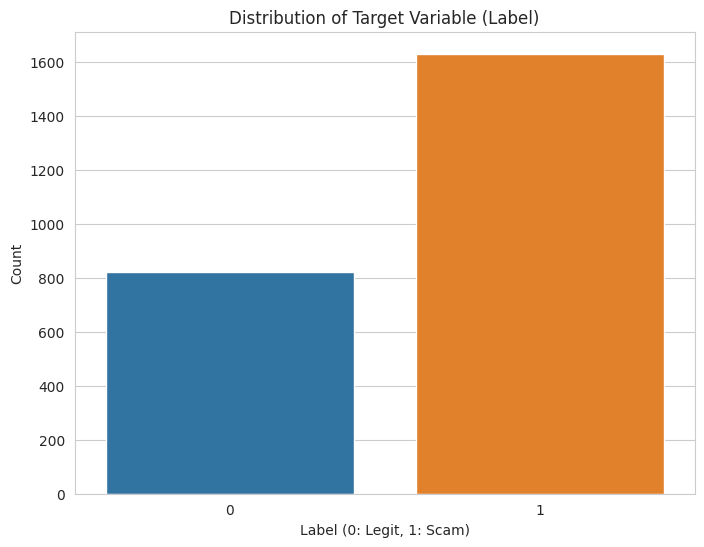

In [ ]:
# Set style
sns.set_style("whitegrid")

# Distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(data=combined_data, x='label')
plt.title('Distribution of Target Variable (Label)')
plt.xlabel('Label (0: Legit, 1: Scam)')
plt.ylabel('Count')
plt.show()


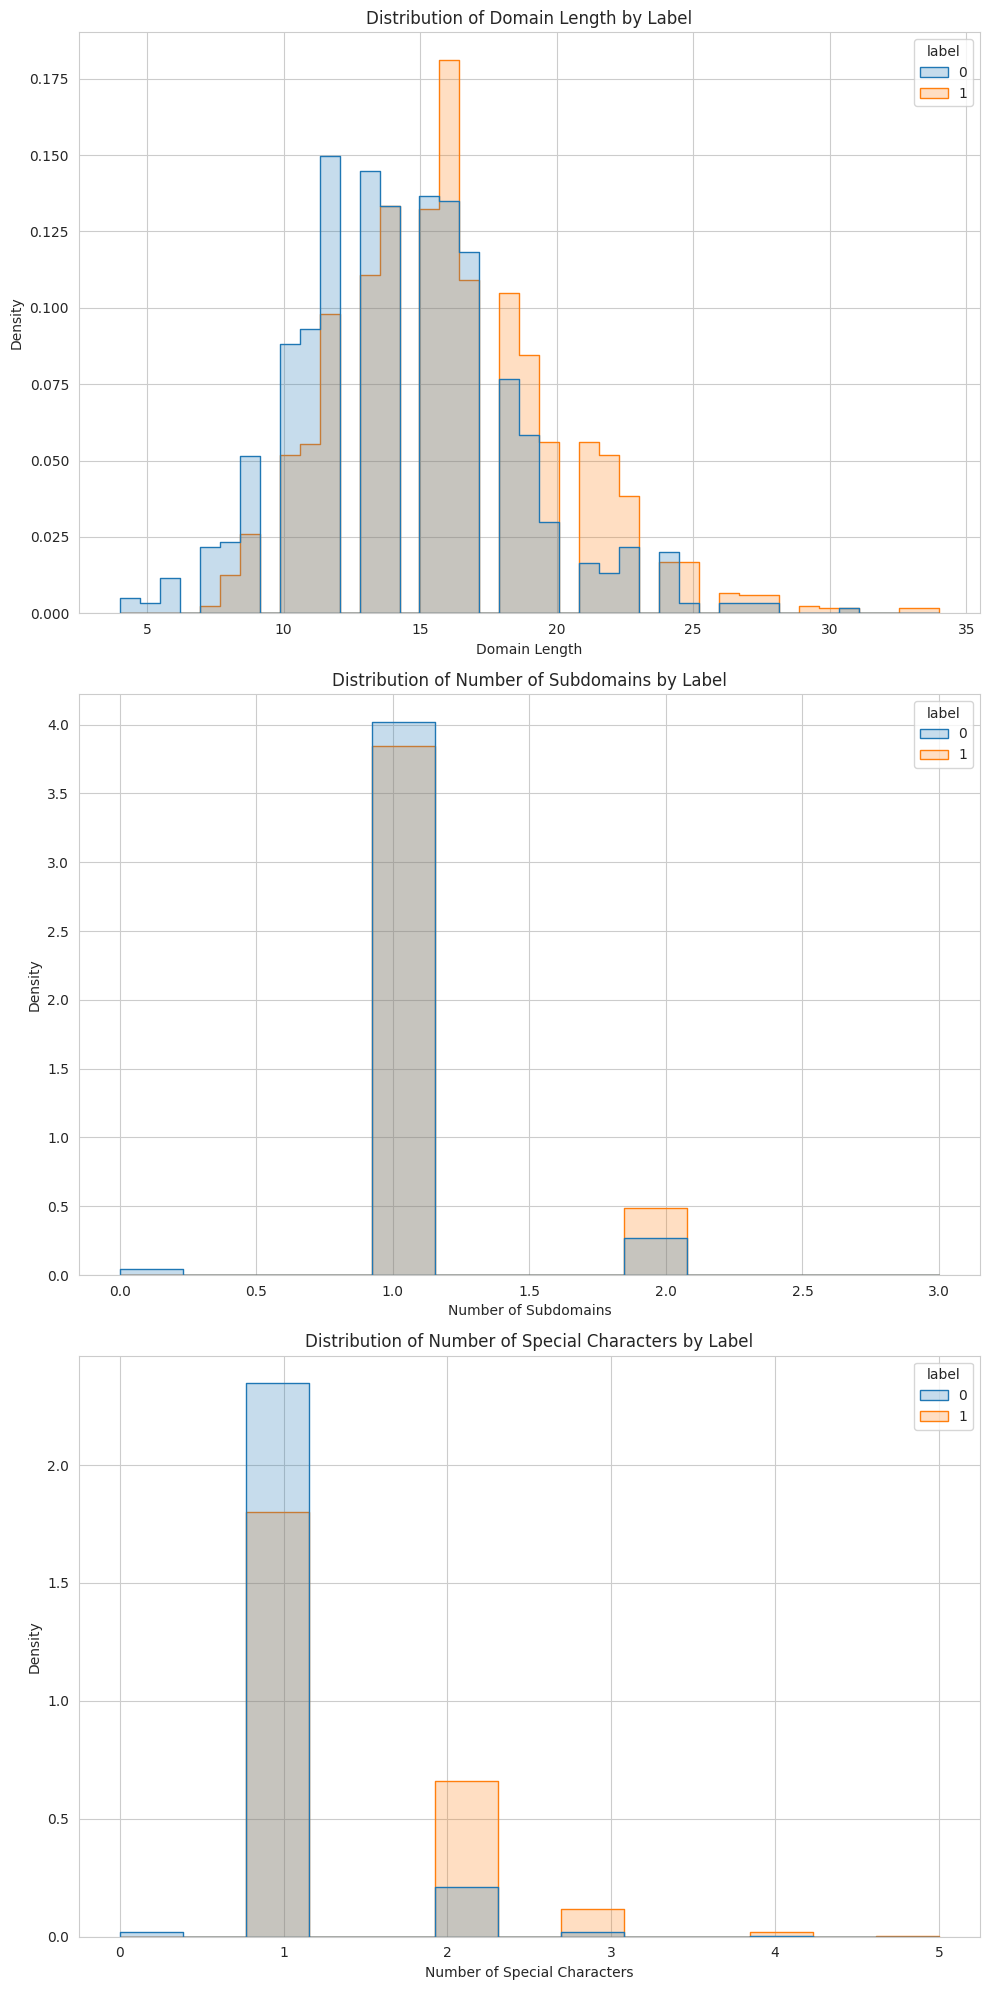

In [ ]:
# Exploring the distribution of numerical features
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

# Distribution of domain_length
sns.histplot(data=combined_data, x='domain_length', hue='label', element="step", stat="density", common_norm=False, ax=axes[0])
axes[0].set_title('Distribution of Domain Length by Label')
axes[0].set_xlabel('Domain Length')
axes[0].set_ylabel('Density')

# Distribution of num_dots
sns.histplot(data=combined_data, x='num_subdomains', hue='label', element="step", stat="density", common_norm=False, ax=axes[1])
axes[1].set_title('Distribution of Number of Subdomains by Label')
axes[1].set_xlabel('Number of Subdomains')
axes[1].set_ylabel('Density')

# Distribution of num_special_chars
sns.histplot(data=combined_data, x='num_special_chars', hue='label', element="step", stat="density", common_norm=False, ax=axes[2])
axes[2].set_title('Distribution of Number of Special Characters by Label')
axes[2].set_xlabel('Number of Special Characters')
axes[2].set_ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show()

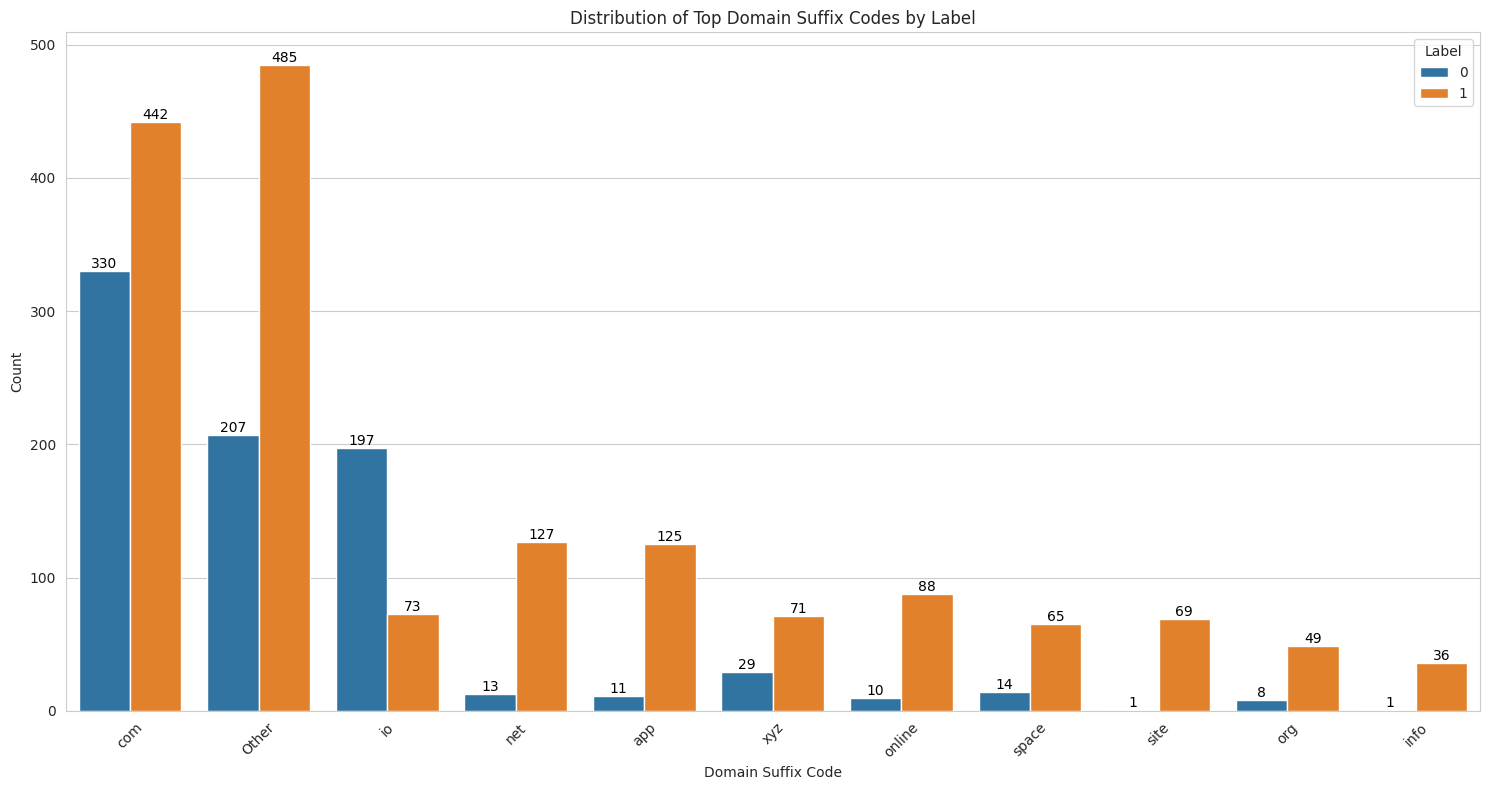

In [ ]:
# Determine the top n domain suffix codes
n = 10
top_suffixes = combined_data['domain_suffix_code'].value_counts().head(n).index

# Replace other suffixes with "Other"
combined_data['displayed_suffix'] = combined_data['domain_suffix_code'].apply(lambda x: x if x in top_suffixes else 'Other')

# Plot
plt.figure(figsize=(15, 8))
sns.countplot(data=combined_data, x='displayed_suffix', hue='label', order=combined_data['displayed_suffix'].value_counts().index)
plt.title('Distribution of Top Domain Suffix Codes by Label')
plt.xlabel('Domain Suffix Code')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Label', loc='upper right')
plt.tight_layout()

# Annotate bars with their respective counts
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')

plt.show()

In [ ]:
combined_data = combined_data.drop(columns=['displayed_suffix'])

In [ ]:
# Encoding the domain_suffix_code
label_encoder = LabelEncoder()
combined_data['domain_suffix_code'] = label_encoder.fit_transform(combined_data['domain_suffix_code'])

In [ ]:
# TF-IDF Tokenization
tfidf_vectorizer = TfidfVectorizer(max_features=100)
url_tfidf = tfidf_vectorizer.fit_transform(combined_data['url'])
url_tfidf_df = pd.DataFrame(url_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
combined_data_2 = pd.concat([combined_data, url_tfidf_df], axis=1)

combined_data_2.drop(columns=['url'], inplace=True)

combined_data_2.head()

,label,url_encoded,domain_length,num_special_chars,num_subdomains,has_http,has_https,has_www,has_numbers,domain_suffix_code,...,uno,v2,web,website,work,world,xyz,y00ts,yoots,zerium
0,1,184,19,2,1,0,0,0,0,74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1422,14,1,1,0,0,0,0,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,133,10,1,1,0,0,0,0,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2101,12,1,1,0,0,0,0,74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2130,13,1,1,0,0,0,0,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Splitting the data
X = combined_data_2.drop("label", axis=1)
y = combined_data_2["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate a pre-trained model using test data, calculate metrics, and print them.

    Parameters:
    - model: Pre-trained machine learning model
    - X_test: Testing/validation data
    - y_test: Labels for the testing/validation data
    """

    # Make predictions using the provided model
    predictions = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)

    # Print the metrics in a readable format
    print(f"Model Metrics:")
    print(f"Accuracy:  {accuracy*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall:    {recall*100:.2f}%")
    print(f"F1 Score:  {f1*100:.2f}%")

    return accuracy, precision, recall, f1


In [ ]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
print(f"RandomForest Results:")
metrics = evaluate_model(rf_model, X_test, y_test)

RandomForest Results:
Model Metrics:
Accuracy:  79.43%
Precision: 82.85%
Recall:    87.16%
F1 Score:  84.95%


In [ ]:
# Hyperparameter tuning for RandomForest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf_clf = grid_search.best_estimator_

# Print the metrics in a readable format
print(f"Tuned RandomForest Results:")
metrics = evaluate_model(best_rf_clf, X_test, y_test)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Tuned RandomForest Results:
Model Metrics:
Accuracy:  81.87%
Precision: 85.21%
Recall:    88.07%
F1 Score:  86.62%


In [ ]:
# Random forrest with bagging
bagging_clf = BaggingClassifier(estimator=RandomForestClassifier(n_estimators=100, random_state=42),
                                n_estimators=10, random_state=42)
bagging_clf.fit(X_train, y_train)
# Evaluation
metrics = evaluate_model(bagging_clf, X_test, y_test)
y_pred_bagging = bagging_clf.predict(X_test)

Model Metrics:
Accuracy:  81.47%
Precision: 85.12%
Recall:    87.46%
F1 Score:  86.27%


In [ ]:
# Random Forest with TF-IDF
rf_clf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_tfidf.fit(X_train, y_train)
metrics = evaluate_model(rf_clf_tfidf, X_test, y_test)

Model Metrics:
Accuracy:  79.43%
Precision: 82.85%
Recall:    87.16%
F1 Score:  84.95%


In [ ]:
# Random forrest with SMOTE balancer
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Training Random Forest on the SMOTE balanced data
rf_clf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_smote.fit(X_train_smote, y_train_smote)

print(f"SMOTE RandomForest Results:")
metrics = evaluate_model(rf_clf_smote, X_test, y_test)

SMOTE RandomForest Results:
Model Metrics:
Accuracy:  78.82%
Precision: 84.74%
Recall:    83.18%
F1 Score:  83.95%


In [ ]:
# Initializing the LightGBM model
lgbm_model = lgb.LGBMClassifier(objective='binary', class_weight='balanced', random_state=42)

# Training the model
lgbm_model.fit(X_train, y_train)

# Evaluation
print(f"LightGBM")
metrics = evaluate_model(lgbm_model, X_test, y_test)

[LightGBM] [Info] Number of positive: 1303, number of negative: 657
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 1960, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM
Model Metrics:
Accuracy:  79.63%
Precision: 88.74%
Recall:    79.51%
F1 Score:  83.87%


In [ ]:
# XGBoost
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
# Evaluation
print(f"XGBClassifier")
metrics = evaluate_model(xgb_model, X_test, y_test)

XGBClassifier
Model Metrics:
Accuracy:  84.32%
Precision: 88.34%
Recall:    88.07%
F1 Score:  88.21%


In [ ]:
y_pred_xgb = xgb_model.predict(X_test)

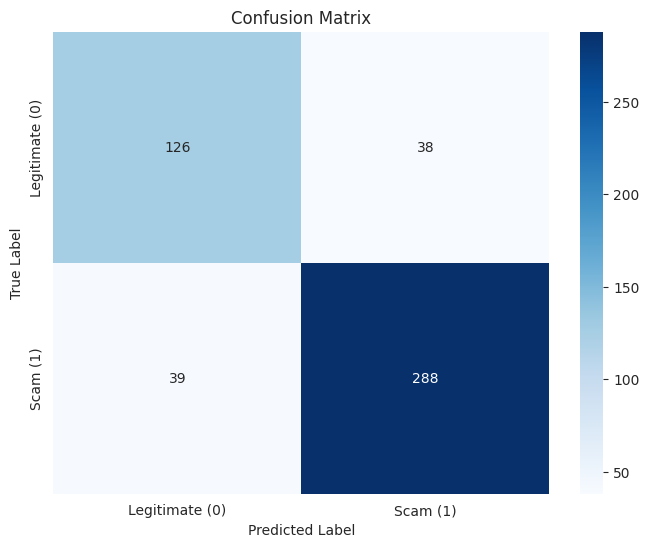

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Legitimate (0)', 'Scam (1)'],
            yticklabels=['Legitimate (0)', 'Scam (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

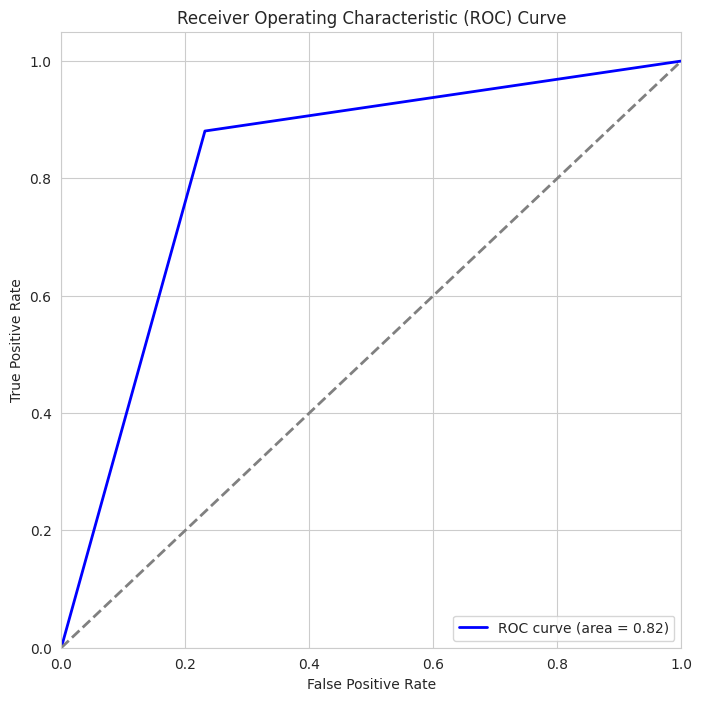

In [ ]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_xgb)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import xgboost as xgb

# Assuming X_train and y_train are already defined and preprocessed
dtrain = xgb.DMatrix(X_train, label=y_train)

params = {
    'colsample_bytree': 0.5,
    'learning_rate': 0.3,
    'max_depth': 3,
    'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 1.0,
    'objective': 'binary:logistic',   # Assuming it's a binary classification task
    'eval_metric': 'logloss'          # Logarithmic loss as the evaluation metric
}

num_rounds = 200  # The number of boosting rounds or trees to build
nfold = 5         # Number of cross-validation folds

cv_results = xgb.cv(params, dtrain, num_boost_round=num_rounds, nfold=nfold,
                    early_stopping_rounds=50, verbose_eval=True, seed=42)

[20:16:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[20:16:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[20:16:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[20:16:17] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[20:16:18] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-logloss:0.62534+0.00300	test-logloss:0.62807+0.00637
[1]	train-logloss:0.58682+0.00529	test-logloss:0.59503+0.01157
[2]	train-logloss:0.56140+0.00615	test-logloss:0.57604+0.01386
[3]	train-logloss:0.54499+0.00829	test-logloss:0.56277+0.01220
[4]	train-logloss:0.52917+0.00678	test-logloss:0.55186+0.01471
[5]	train-logloss:0.51702+0.00593	test-logloss:0.54348+0.01830
[6]	train-logloss:0.50375+0.00531	test-logloss:0.53512+0.01914
[7]	train-logloss:0.49438+0.00607	test-logloss:0.52979+0.01847
[8]	train-logloss:0.48576+0.00656	test-logloss

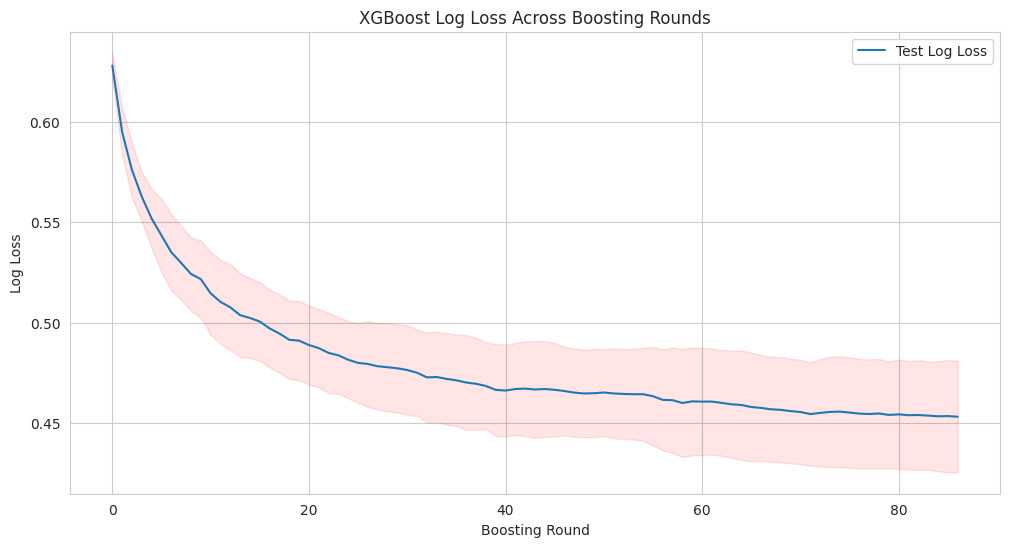

In [ ]:
import matplotlib.pyplot as plt

# Extract mean and standard deviation from cv_results
mean_logloss = cv_results['test-logloss-mean']
std_logloss = cv_results['test-logloss-std']

# Create a range for x-axis
x_axis = range(0, len(mean_logloss))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(x_axis, mean_logloss, label='Test Log Loss')
plt.fill_between(x_axis, mean_logloss - std_logloss, mean_logloss + std_logloss, color='r', alpha=0.1)
plt.title('XGBoost Log Loss Across Boosting Rounds')
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.show()

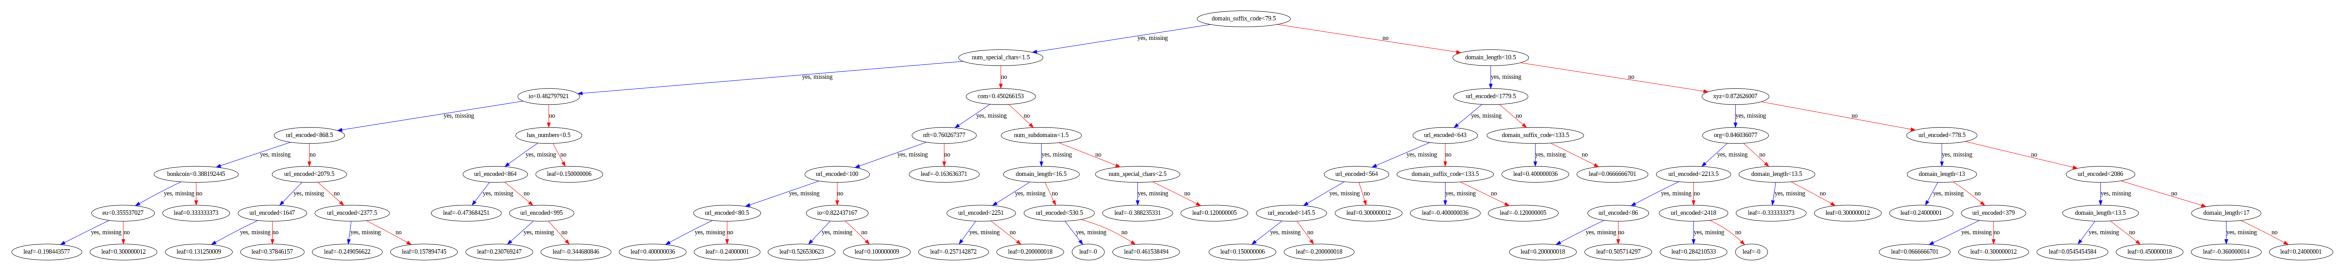

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(xgb_model, num_trees=0, ax=ax)
plt.show()

<Figure size 1500x1000 with 0 Axes>

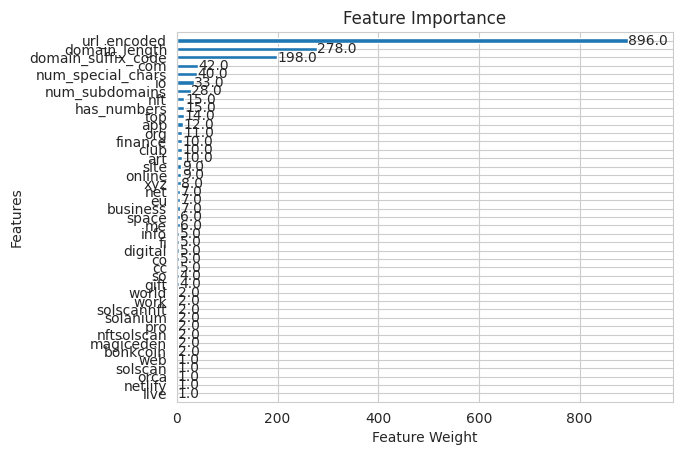

In [ ]:
# Plot the first tree
plt.figure(figsize=(15, 10))
xgb.plot_importance(xgb_model, importance_type='weight', title='Feature Importance', xlabel='Feature Weight', height=0.5)
plt.show()

In [ ]:
# # SVM
# svm_model = SVC(kernel='linear', probability=True, random_state=42)
# svm_model.fit(X_train, y_train)
# svm_predictions = svm_model.predict(X_test)
# svm_metrics = (accuracy_score(y_test, svm_predictions), precision_score(y_test, svm_predictions), recall_score(y_test, svm_predictions), f1_score(y_test, svm_predictions))

# svm_metrics

In [ ]:
# # Scaler for SVC
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# svm_model_scaled = SVC(kernel='linear', random_state=42)
# svm_model_scaled.fit(X_train_scaled, y_train)
# svm_predictions_scaled = svm_model_scaled.predict(X_test_scaled)

In [ ]:
# accuracy_scaled = accuracy_score(y_test, svm_predictions_scaled)
# precision_scaled = precision_score(y_test, svm_predictions_scaled)
# recall_scaled = recall_score(y_test, svm_predictions_scaled)
# f1_scaled = f1_score(y_test, svm_predictions_scaled)
# print(accuracy_scaled, precision_scaled, recall_scaled, f1_scaled)


In [ ]:
# # Ensemble Method (RF + XGB)
# ensemble_predictions = (rf_model.predict_proba(X_test)[:, 1] + xgb_model.predict_proba(X_test)[:, 1]) / 2
# ensemble_final_predictions = [1 if prob > 0.5 else 0 for prob in ensemble_predictions]

In [ ]:
# ensemble_metrics = (accuracy_score(y_test, ensemble_final_predictions), precision_score(y_test, ensemble_final_predictions), recall_score(y_test, ensemble_final_predictions), f1_score(y_test, ensemble_final_predictions))

# ensemble_metrics

In [ ]:
# # Anomaly detection, poor results

# # Reload the datasets
# scam_df = pd.read_csv('/content/drive/MyDrive/Master/Project/Domains/final_blocklist_domains.csv')
# legit_df = pd.read_csv('/content/drive/MyDrive/Master/Project/Domains/final_legit_domains.csv')

# # Split the legitimate URLs for training and testing
# legit_train, legit_test = train_test_split(legit_df, test_size=0.2, random_state=42)

# # For anomaly detection, we'll train on the legit_train set and test on both legit_test and scam_df
# X_train = legit_train['Unique Domains'].fillna("")
# X_test = pd.concat([legit_test['Unique Domains'].fillna(""), scam_df['url'].fillna("")])

# # Labels for evaluation
# y_test = [0] * len(legit_test) + [1] * len(scam_df)

# # Convert the URL strings to a format suitable for the model using TF-IDF
# tfidf_vectorizer_anomaly = TfidfVectorizer(ngram_range=(1, 2), max_features=100)
# X_train_tfidf = tfidf_vectorizer_anomaly.fit_transform(X_train).toarray()  # Convert to array format
# X_test_tfidf = tfidf_vectorizer_anomaly.transform(X_test).toarray()  # Convert to array format

# # Train the Isolation Forest model
# iso_forest = IsolationForest(contamination=0.05, random_state=42)
# iso_forest.fit(X_train_tfidf)

# # Predict on the test set
# predictions = [-1 if x == 1 else 1 for x in iso_forest.predict(X_test_tfidf)]

# # Evaluate the model
# report = classification_report(y_test, predictions)

# report


In [ ]:
# 1. Tokenize and convert URLs to sequences
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(combined_data['url'])
sequences = tokenizer.texts_to_sequences(combined_data['url'])

# 2. Find the max length of sequences and pad
max_length = max([len(seq) for seq in sequences])
X_padded = pad_sequences(sequences, maxlen=max_length)

In [ ]:
# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, combined_data['label'], test_size=0.2, random_state=42)

# 4. Build and train the RNN model
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length))
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Bidirectional LSTM layer
model.add(Dropout(0.2))  # Dropout for regularization
model.add(LSTM(64))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
62/62 [==============================] - 15s 113ms/step - loss: 0.6265 - accuracy: 0.6617 - val_loss: 0.5430 - val_accuracy: 0.7271
Epoch 2/20
62/62 [==============================] - 6s 96ms/step - loss: 0.5268 - accuracy: 0.7327 - val_loss: 0.4868 - val_accuracy: 0.7617
Epoch 3/20
62/62 [==============================] - 4s 65ms/step - loss: 0.4811 - accuracy: 0.7770 - val_loss: 0.4605 - val_accuracy: 0.7821
Epoch 4/20
62/62 [==============================] - 7s 110ms/step - loss: 0.4713 - accuracy: 0.7806 - val_loss: 0.4487 - val_accuracy: 0.7902
Epoch 5/20
62/62 [==============================] - 5s 86ms/step - loss: 0.4524 - accuracy: 0.7898 - val_loss: 0.4499 - val_accuracy: 0.7841
Epoch 6/20
62/62 [==============================] - 4s 67ms/step - loss: 0.4462 - accuracy: 0.8077 - val_loss: 0.4580 - val_accuracy: 0.7821
Epoch 7/20
62/62 [==============================] - 5s 73ms/step - loss: 0.4469 - accuracy: 0.8026 - val_loss: 0.4732 - val_accuracy: 0.7719
Epoch 8/20

In [ ]:
# Return the final training accuracy and validation accuracy
history.history['accuracy'][-1], history.history['val_accuracy'][-1]

(0.8352040648460388, 0.7963340282440186)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Enhanced LTSM Model Accuracy: {accuracy * 100:.2f}%")

16/16 [==============================] - 4s 33ms/step - loss: 0.3961 - accuracy: 0.8496
Enhanced LTSM Model Accuracy: 84.96%


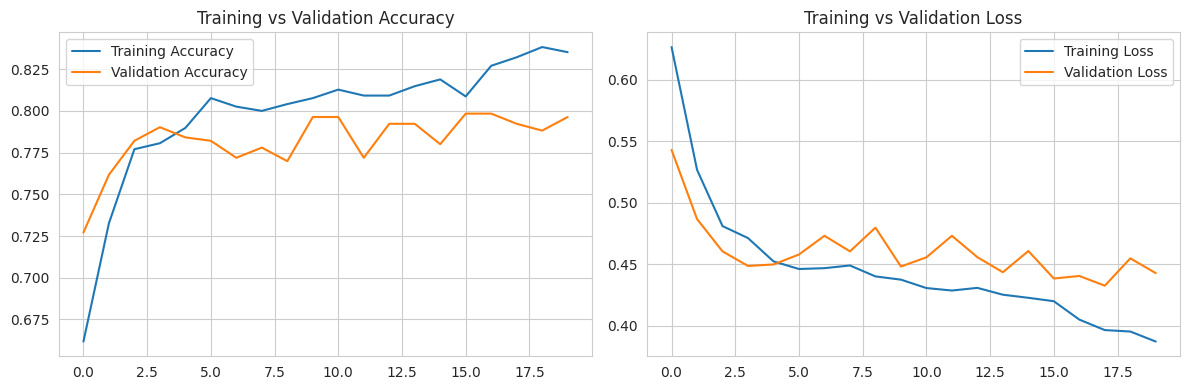

In [ ]:
# Plotting training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.tight_layout()
plt.show()

In [ ]:
# # Tokenize the URLs at the character level
# tokenizer = Tokenizer(char_level=True)
# tokenizer.fit_on_texts(combined_data['url'])

# # Convert URLs to sequences of integers
# sequences = tokenizer.texts_to_sequences(combined_data['url'])

# max_length = max([len(seq) for seq in sequences])

# # Pad sequences to ensure uniform length
# X = pad_sequences(sequences, maxlen=max_length)
# y = combined_data['label'].values

# # Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# # Define the GRU model
# gru_model = Sequential()
# gru_model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length))
# gru_model.add(GRU(64, return_sequences=True))
# gru_model.add(Dropout(0.5))
# gru_model.add(GRU(64))
# gru_model.add(Dropout(0.5))
# gru_model.add(Dense(1, activation='sigmoid'))

# # Adjusting the learning rate
# optimizer = Adam(learning_rate=0.001)

# gru_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# # Early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# # Fit the model to the training data
# gru_history_improved = gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
62/62 [==============================] - 8s 72ms/step - loss: 0.6343 - accuracy: 0.6628 - val_loss: 0.5869 - val_accuracy: 0.6701
Epoch 2/20
62/62 [==============================] - 4s 60ms/step - loss: 0.5447 - accuracy: 0.7403 - val_loss: 0.5164 - val_accuracy: 0.7719
Epoch 3/20
62/62 [==============================] - 3s 43ms/step - loss: 0.4998 - accuracy: 0.7724 - val_loss: 0.4981 - val_accuracy: 0.7617
Epoch 4/20
62/62 [==============================] - 3s 43ms/step - loss: 0.4631 - accuracy: 0.7893 - val_loss: 0.4644 - val_accuracy: 0.8065
Epoch 5/20
62/62 [==============================] - 3s 42ms/step - loss: 0.4554 - accuracy: 0.7908 - val_loss: 0.4622 - val_accuracy: 0.7902
Epoch 6/20
62/62 [==============================] - 4s 68ms/step - loss: 0.4515 - accuracy: 0.7903 - val_loss: 0.4617 - val_accuracy: 0.7841
Epoch 7/20
62/62 [==============================] - 3s 54ms/step - loss: 0.4475 - accuracy: 0.8077 - val_loss: 0.4699 - val_accuracy: 0.8024
Epoch 8/20
62

In [ ]:
# # Evaluate
# accuracy = gru_model.evaluate(X_test, y_test)[1]
# print(f"Enhanced GRU Model Accuracy: {accuracy * 100:.2f}%")

16/16 [==============================] - 0s 16ms/step - loss: 0.4324 - accuracy: 0.8086
Enhanced GRU Model Accuracy: 80.86%


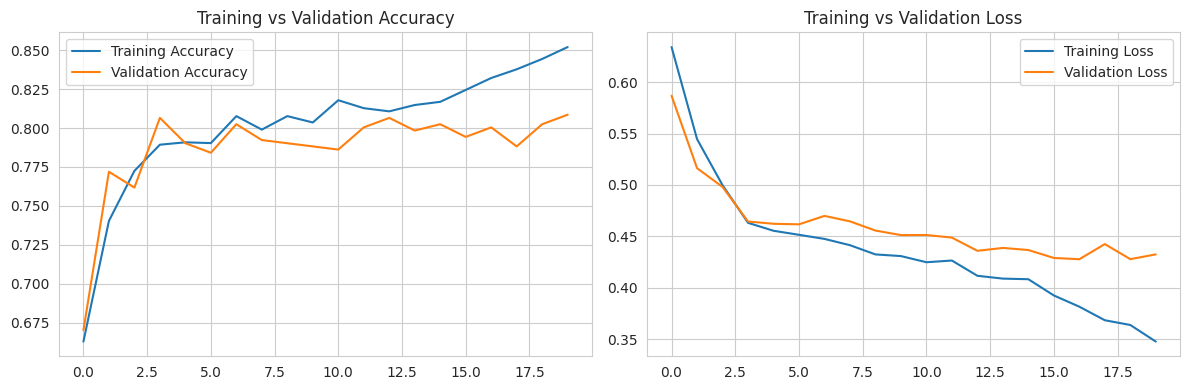

In [ ]:
# # Plotting training & validation accuracy
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(gru_history_improved.history['accuracy'], label='Training Accuracy')
# plt.plot(gru_history_improved.history['val_accuracy'], label='Validation Accuracy')
# plt.legend()
# plt.title('Training vs Validation Accuracy')

# # Plotting training & validation loss
# plt.subplot(1, 2, 2)
# plt.plot(gru_history_improved.history['loss'], label='Training Loss')
# plt.plot(gru_history_improved.history['val_loss'], label='Validation Loss')
# plt.legend()
# plt.title('Training vs Validation Loss')
# plt.tight_layout()
# plt.show()